In [54]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch_geometric as tg

sns.set()

In [55]:
df = pd.read_csv("Test_DGA_network.tsv", sep="\t", names=["disease", "gene"])

In [56]:
df.head()

,disease,gene
0,C0001418,8289
1,C0011853,7040
2,C0009375,1956
3,C0279626,4853
4,C0205642,7422


In [57]:
df.gene = df.gene.astype(str)

In [58]:
G = nx.Graph()
G.add_nodes_from(df.disease, bipartite="disease", y=0)
G.add_nodes_from(df.gene, bipartite="gene", y=1)
G.add_edges_from(zip(df.disease.tolist(), df.gene.tolist()))

# G = nx.from_pandas_edgelist(df, source="disease", target="gene")


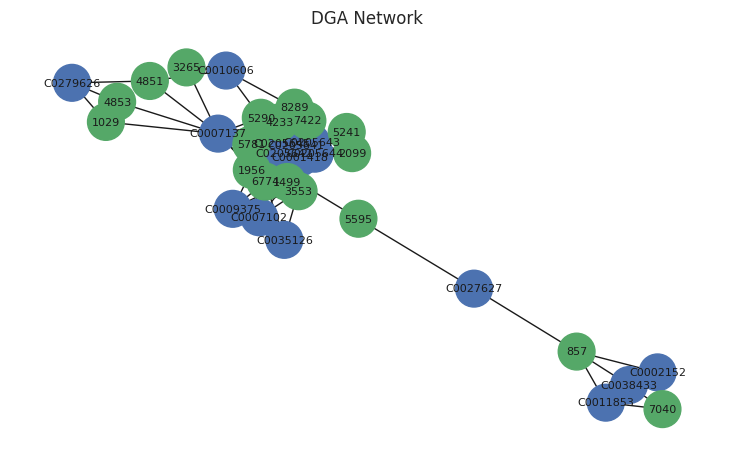

In [59]:
plt.figure(1, figsize=(8, 5))
plt.title("DGA Network")
plt.tight_layout()

color = nx.bipartite.color(G)
color_dict = {"disease": "b", "gene":"g"}
color_list = [color_dict[i[1]] for i in G.nodes.data("bipartite")]
nx.draw(G, pos=nx.spring_layout(G, seed=10), with_labels=True, node_color=color_list, node_size=700, font_size=8)
# nx.draw(G, pos=nx.shell_layout(G))

In [60]:
data = tg.utils.from_networkx(G)

In [61]:
print(data.edge_index.shape)

torch.Size([2, 204])


In [62]:
print(data.is_directed())
print(data.has_isolated_nodes())
print(data.has_self_loops())


False
False
False


In [63]:
data

Data(edge_index=[2, 204], y=[34], bipartite=[34], num_nodes=34)

Split training and testing set

- just split it (pseudo)randomly

In [64]:
# import random

# train_mask = ([True] * 4) + ([False] * 30)
# random.Random(4).shuffle(train_mask)
train_mask = torch.rand(34, generator=torch.Generator().manual_seed(10)) > 0.9

In [65]:
data.train_mask = torch.Tensor(train_mask)
data.x = torch.eye(34)  # identitiy matrix for node features (doesnt do anything)

In [66]:
data.train_mask

tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])

## GCN

In [67]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(34, 3)
        self.out = Linear(3, 2)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z


model = GCN()
print(model)


GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=2, bias=True)
)


In [68]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)


# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)


# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, z = model(data.x, data.edge_index)

    # Calculate loss function
    loss = criterion(z, data.y)

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%")


Epoch   0 | Loss: 0.70 | Acc: 52.94%
Epoch  10 | Loss: 0.60 | Acc: 88.24%
Epoch  20 | Loss: 0.45 | Acc: 100.00%
Epoch  30 | Loss: 0.29 | Acc: 100.00%
Epoch  40 | Loss: 0.18 | Acc: 100.00%
Epoch  50 | Loss: 0.12 | Acc: 100.00%
Epoch  60 | Loss: 0.08 | Acc: 100.00%
Epoch  70 | Loss: 0.06 | Acc: 100.00%
Epoch  80 | Loss: 0.05 | Acc: 100.00%
Epoch  90 | Loss: 0.04 | Acc: 100.00%
Epoch 100 | Loss: 0.03 | Acc: 100.00%
Epoch 110 | Loss: 0.03 | Acc: 100.00%
Epoch 120 | Loss: 0.02 | Acc: 100.00%
Epoch 130 | Loss: 0.02 | Acc: 100.00%
Epoch 140 | Loss: 0.02 | Acc: 100.00%
Epoch 150 | Loss: 0.02 | Acc: 100.00%
Epoch 160 | Loss: 0.01 | Acc: 100.00%
Epoch 170 | Loss: 0.01 | Acc: 100.00%
Epoch 180 | Loss: 0.01 | Acc: 100.00%
Epoch 190 | Loss: 0.01 | Acc: 100.00%
Epoch 200 | Loss: 0.01 | Acc: 100.00%


In [69]:
%%capture
from matplotlib import animation
from IPython.display import HTML

plt.rcParams["animation.bitrate"] = 3000


def animate(i):
    # G = tg.utils.to_networkx(data, to_undirected=True)
    nx.draw(
        G,
        pos=nx.spring_layout(G, seed=10),
        with_labels=True,
        node_size=800,
        node_color=outputs[i],
        cmap="hsv",
        vmin=-2,
        vmax=3,
        width=0.8,
        font_size=14,
    )
    plt.title(
        f"Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%",
        fontsize=18,
        pad=20,
    )


fig = plt.figure(figsize=(7, 7))
plt.axis("off")

anim = animation.FuncAnimation(
    fig,
    animate,
    np.arange(0, 200, 10),
    interval=500,
    repeat=True,
)

html = HTML(anim.to_html5_video())

In [70]:
display(html)

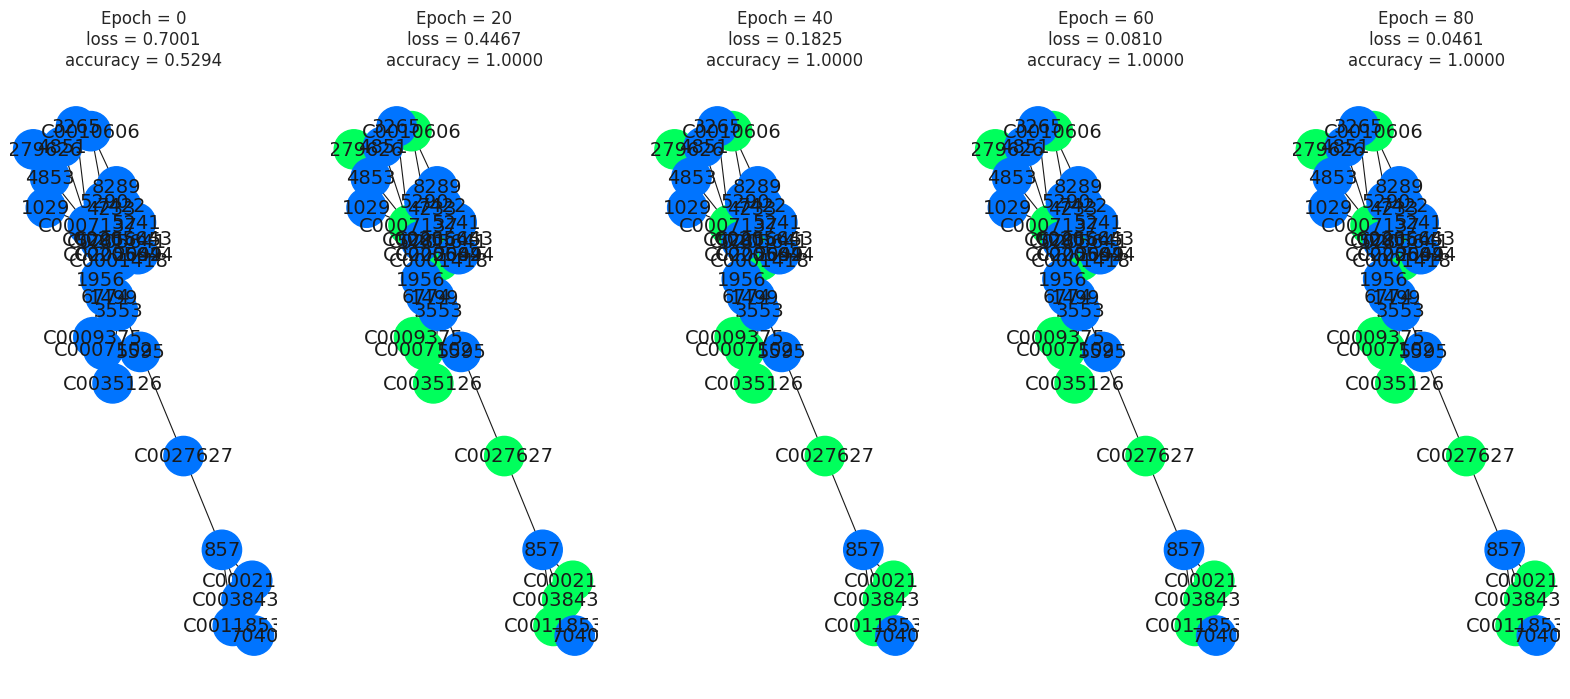

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 8), squeeze=0)

for i, ax in enumerate(axes.flatten()):
    i = i * 20
    nx.draw(
        G,
        pos=nx.spring_layout(G, seed=10),
        with_labels=True,
        node_size=800,
        node_color=outputs[i],
        cmap="hsv",
        vmin=-2,
        vmax=3,
        width=0.8,
        font_size=14,
        ax=ax,
    )
    ax.set_title(
        f"Epoch = {i}\nloss = {losses[i]:0.4f}\naccuracy = {accuracies[i]:0.4f}"
    )
    # ax.set_axis_off()


In [72]:
%%capture
def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(
        embed[:, 0],
        embed[:, 1],
        embed[:, 2],
        s=200,
        c=data.y,
        cmap="hsv",
        vmin=-2,
        vmax=3,
    )
    plt.title(
        f"Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%",
        fontsize=18,
        pad=40,
    )


fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ax = fig.add_subplot(projection="3d")
plt.tick_params(
    left=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)


anim = animation.FuncAnimation(
    fig,
    animate,
    np.arange(0, 200, 10),
    interval=800,
    repeat=True,
)
html = HTML(anim.to_html5_video())


In [73]:
display(html)

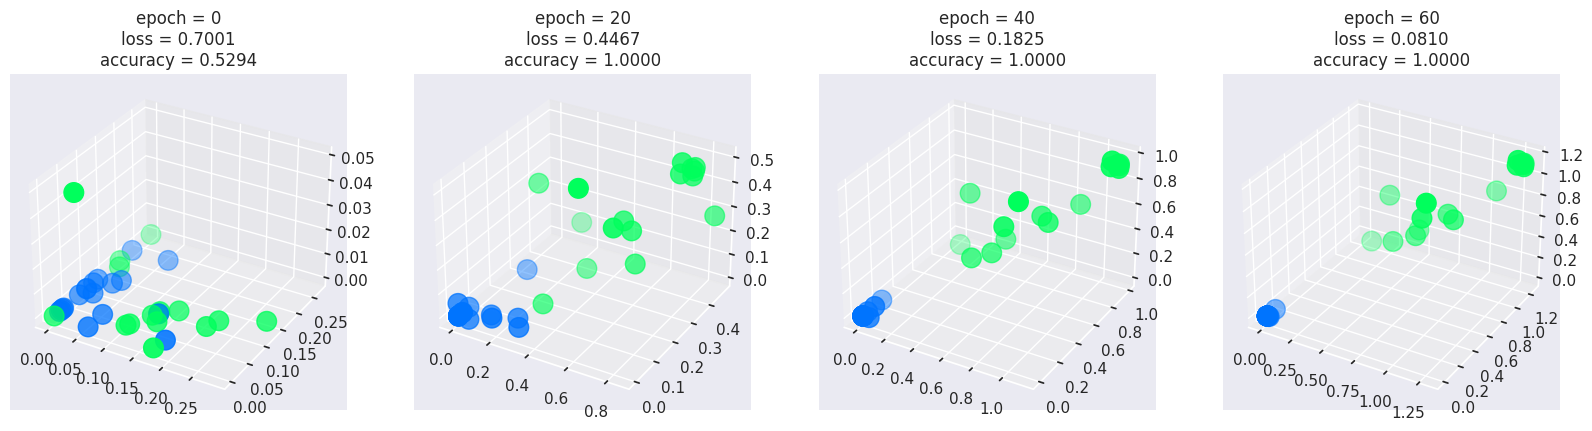

In [74]:
fig = plt.figure(figsize=(20, 8))


for i in range(4):
    # i = i * 50
    ind = i * 20

    ax = fig.add_subplot(1, 4, i + 1, projection="3d")

    embed = embeddings[ind].detach().cpu().numpy()
    ax.clear()
    ax.scatter(
        embed[:, 0],
        embed[:, 1],
        embed[:, 2],
        s=200,
        c=data.y,
        cmap="hsv",
        vmin=-2,
        vmax=3,
    )

    ax.set_title(
        f"epoch = {ind}\nloss = {losses[ind]:0.4f}\naccuracy = {accuracies[ind]:0.4f}"
    )
    # ax.tick_params(
    #     left=False,
    #     bottom=False,
    #     labelleft=False,
    #     labelbottom=False,
    # )
